In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import pipeline

c:\Users\super\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
%pip install transformers

Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/44.4 kB ? eta -:--:--
     -------------------------- ----------- 30.7/44.4 kB 660.6 kB/s eta 0:00:01
     -------------------------------------- 44.4/44.4 kB 437.6 kB/s eta 0:00:00
     ---------------------------------------- 0.0/41.5 kB ? eta -:--:--
     ---------------------------------------  41.0/41.5 kB 2.0 MB/s eta 0:00:01
     -------------------------------------- 41.5/41.5 kB 680.6 kB/s eta 0:00:00
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ----------------------------------- ---- 51.2/57.6 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 763.9 kB/s eta 0:00:00
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
    --------------------------------------- 0.2/9.9 MB 3.3 MB/s eta 0:00:03
   - -------------------------------------- 0.3/9.9 MB 3.1 MB/s eta 0:00:04
   - ------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
df = pd.read_pickle("reviews.pkl")

In [3]:
def preprocessing(df):
    df.drop(
        columns=[
            "images",
            "language",
            "url",
            "userId",
            "index",
            "restaurantId",
            "reviewId",
        ],
        inplace=True,
    )
    df["date"] = df["date"].apply(lambda x: x.split()[::2])
    mes = {
        "enero": "01",
        "febrero": "02",
        "marzo": "03",
        "abril": "04",
        "mayo": "05",
        "junio": "06",
        "julio": "07",
        "agosto": "08",
        "septiembre": "09",
        "octubre": "10",
        "noviembre": "11",
        "diciembre": "12",
    }
    df["mes"] = df["date"].apply(lambda x: mes[x[1]])
    df["date"] = df[["date", "mes"]].apply(
        lambda x: str(x[0][0]) + "-" + str(x[1]) + "-" + str(x[0][2]), axis=1
    )
    df.drop(columns=["mes"], inplace=True)
    df["date"] = pd.to_datetime(df["date"])
    return df

In [4]:
df = preprocessing(df)

C:\Users\jilai\AppData\Local\Temp\ipykernel_14612\3951252518.py:34: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["date"] = pd.to_datetime(df["date"])


In [2]:
from transformers import pipeline

distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", 
    return_all_scores=True
)

c:\Users\super\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\super\.cache\huggingface\hub\models--lxyuan--distilbert-base-multilingual-cased-sentiments-student. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\super\AppData\Local\Programs\Python\Python31

In [6]:
def get_higher_sentiment_score(sentiment_scores):
    max = [(scores["score"], scores["label"]) for scores in sentiment_scores[0]]
    max.sort(reverse=True)
    return max[0][1]


In [7]:
"""
df2 = df.copy().iloc[:1000]
df2["sentiment"] = df2["text"].apply(lambda x: get_higher_sentiment_score(distilled_student_sentiment_classifier(x)))
df2.to_pickle("reviews_with_sentiment.pkl")
"""

'\ndf2 = df.copy().iloc[:1000]\ndf2["sentiment"] = df2["text"].apply(lambda x: get_higher_sentiment_score(distilled_student_sentiment_classifier(x)))\ndf2.to_pickle("reviews_with_sentiment.pkl")\n'

In [4]:
df2 = pd.read_pickle("reviews_with_sentiment.pkl")

In [5]:
df2["rating-sentiment"] = df2[["rating", "sentiment"]].apply(lambda x: 1 if (x[0] > 30 and x[1] == "positive") or (x[0] == 30 and x[1]=="neutral") or (x[0] < 30 and x[1]=="negative") else 0, axis=1)

C:\Users\super\AppData\Local\Temp\ipykernel_20640\476950203.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df2["rating-sentiment"] = df2[["rating", "sentiment"]].apply(lambda x: 1 if (x[0] > 30 and x[1] == "positive") or (x[0] == 30 and x[1]=="neutral") or (x[0] < 30 and x[1]=="negative") else 0, axis=1)


In [7]:
df2.head()

,date,rating,text,title,sentiment,rating-sentiment
0,2017-04-26,30,"Si quieres comer abundante, bien y sin floritu...",Comida casera muy casera,positive,0
1,2015-08-17,40,cerveceria calsica muy cerquita de la plaza ma...,clasica cerveceria cons sabor autentico,positive,1
2,2018-04-27,50,Una amiga que vive en alameda de Osuna juraba ...,Pasteles increíbles,positive,1
3,2018-04-15,40,"la bolleria genial, el cafe bueno, el personal...",una buena merienda,positive,1
4,2017-12-31,50,Impecable servicio y la mejor calidad y sabor ...,Excelente,positive,1


In [47]:
# Load the regular expression library
import re# Remove punctuation
df2['text_processed'] = \
df2['text'].map(lambda x: re.sub('[,\.!?]', '', x))# Convert the titles to lowercase
df2['text_processed'] = \
df2['text_processed'].map(lambda x: x.lower())# Print out the first rows of papers
df2['text_processed'].head()

# Remove stop words
from nltk.corpus import stopwords
print(stopwords)
stop_words = set(stopwords.words('spanish'))# Function to remove stop words from sentences
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])# Apply the function to remove stop words
df2['text_processed'] = df2['text_processed'].apply(lambda text: remove_stopwords(text))# Print out the first rows of papers

<WordListCorpusReader in 'C:\\Users\\super\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>


<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
C:\Users\super\AppData\Local\Temp\ipykernel_20640\1938332065.py:4: SyntaxWarning: invalid escape sequence '\.'
  df2['text'].map(lambda x: re.sub('[,\.!?]', '', x))# Convert the titles to lowercase


In [48]:
from nltk.corpus import stopwords

for words in stopwords.words('spanish'):
    print(words)

de
la
que
el
en
y
a
los
del
se
las
por
un
para
con
no
una
su
al
lo
como
más
pero
sus
le
ya
o
este
sí
porque
esta
entre
cuando
muy
sin
sobre
también
me
hasta
hay
donde
quien
desde
todo
nos
durante
todos
uno
les
ni
contra
otros
ese
eso
ante
ellos
e
esto
mí
antes
algunos
qué
unos
yo
otro
otras
otra
él
tanto
esa
estos
mucho
quienes
nada
muchos
cual
poco
ella
estar
estas
algunas
algo
nosotros
mi
mis
tú
te
ti
tu
tus
ellas
nosotras
vosotros
vosotras
os
mío
mía
míos
mías
tuyo
tuya
tuyos
tuyas
suyo
suya
suyos
suyas
nuestro
nuestra
nuestros
nuestras
vuestro
vuestra
vuestros
vuestras
esos
esas
estoy
estás
está
estamos
estáis
están
esté
estés
estemos
estéis
estén
estaré
estarás
estará
estaremos
estaréis
estarán
estaría
estarías
estaríamos
estaríais
estarían
estaba
estabas
estábamos
estabais
estaban
estuve
estuviste
estuvo
estuvimos
estuvisteis
estuvieron
estuviera
estuvieras
estuviéramos
estuvierais
estuvieran
estuviese
estuvieses
estuviésemos
estuvieseis
estuviesen
estando
estado
estada
estados
e

In [9]:
df2.head()

,date,rating,text,title,sentiment,rating-sentiment,text_processed
0,2017-04-26,30,"Si quieres comer abundante, bien y sin floritu...",Comida casera muy casera,positive,0,si quieres comer abundante bien florituras ést...
1,2015-08-17,40,cerveceria calsica muy cerquita de la plaza ma...,clasica cerveceria cons sabor autentico,positive,1,cerveceria calsica cerquita plaza mayor tomars...
2,2018-04-27,50,Una amiga que vive en alameda de Osuna juraba ...,Pasteles increíbles,positive,1,amiga vive alameda osuna juraba pasteles buení...
3,2018-04-15,40,"la bolleria genial, el cafe bueno, el personal...",una buena merienda,positive,1,bolleria genial cafe bueno personal simpatico ...
4,2017-12-31,50,Impecable servicio y la mejor calidad y sabor ...,Excelente,positive,1,impecable servicio mejor calidad sabor bollerí...


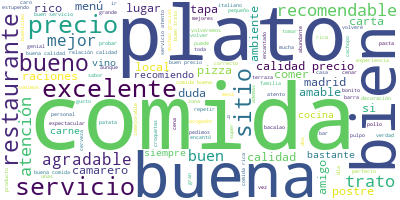

In [40]:
from wordcloud import WordCloud# Join the different processed titles together.
long_string = ','.join(list(df2['text_processed'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

In [27]:
%pip install wordcloud

     ---------------------------------------- 0.0/167.0 kB ? eta -:--:--
     -------------------------------------  163.8/167.0 kB 3.3 MB/s eta 0:00:01
     -------------------------------------- 167.0/167.0 kB 2.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/301.4 kB ? eta -:--:--
   --------------------------------------  297.0/301.4 kB 17.9 MB/s eta 0:00:01
   ---------------------------------------- 301.4/301.4 kB 6.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.8 MB 14.9 MB/s eta 0:00:01
   ----- ---------------------------------- 1.0/7.8 MB 13.3 MB/s eta 0:00:01
   ----- ---------------------------------- 1.1/7.8 MB 14.0 MB/s eta 0:00:01
   ------- -------------------------------- 1.4/7.8 MB 9.1 MB/s eta 0:00:01
   --------- ------------------------------ 1.9/7.8 MB 8.7 MB/s eta 0:00:01
   --------- ------------------------------ 1.9/7.8 MB 8.7 MB/s eta 0:00:01
   -----

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
import json
stop_words = stopwords.words('spanish')
stop_words.extend(["desde", "excelente", "siempre", "bien", "aunque", "solo", "si", "bueno", "así", "muy", "mejor", "buena", "gran", "puede", "puedo", "pueden", "puedes","verdad","ademas","duda","unas"])

with open('sinonimos.json', 'r', encoding='utf-8') as file:
    synonyms_dict = json.load(file)
    synonym_to_word = {synonym: word for word, synonyms in synonyms_dict.items() for synonym in synonyms}

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

def substitute_synonyms(texts):
    substituted_texts = []
    for doc in texts:
        substituted_doc = [] 
        for word in doc:
            cleaned_word = re.sub(r'[^\w\s]', '', word) 

            if cleaned_word in synonym_to_word:
                new_word = synonym_to_word[cleaned_word]  
                replaced_word = word.replace(cleaned_word, new_word)
                substituted_doc.append(replaced_word)  
            else:
                substituted_doc.append(word)  
        substituted_texts.append(substituted_doc) 
    return substituted_texts

    
data = df2["text_processed"].values.tolist()
data_words = list(sent_to_words(data))# remove stop words
data_words = remove_stopwords(data_words)
data_words = substitute_synonyms(data_words)
print(data_words[:1][0][:30])

['quieres', 'comida', 'abundante', 'florituras', 'lugar', 'acude', 'tiempo', 'comida', 'mediodia', 'llena']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
print(data_words)

[['quieres', 'comida', 'abundante', 'florituras', 'lugar', 'acude', 'tiempo', 'comida', 'mediodia', 'llena'], ['cerveceria', 'calsica', 'cerquita', 'plaza', 'mayor', 'tomarse', 'cerveza', 'fresquita', 'pasais', 'dueis', 'parar', 'tomaros'], ['amiga', 'vive', 'alameda', 'osuna', 'juraba', 'pasteles', 'buenisimos', 'compro', 'caja', 'bola', 'grande', 'chocolate', 'kinder', 'feliz', 'toda', 'caja', 'encanto', 'repetir'], ['bolleria', 'inteligente', 'cafe', 'personal', 'simpatico', 'ganas', 'volver', 'probar', 'mas', 'cosas', 'terracita', 'comoda'], ['impecable', 'servicio', 'calidad', 'sabor', 'bolleria', 'buen', 'cafe', 'presentado', 'local', 'acogedor', 'lugar', 'residencial', 'tranquila'], ['cafes', 'servidos', 'dibujo', 'sirven', 'pequenos', 'croissants', 'grandes', 'buenos', 'mantas', 'terraza', 'climatizada', 'taparse', 'agradable'], ['mejores', 'tartas', 'pasteles', 'bolleria', 'pan', 'lugar', 'lugar', 'bareco', 'inteligente', 'tomar', 'cafe'], ['pasteleria', 'situada', 'barrio', '

In [3]:
%pip install gensim
%pip install nltk.tokenize
%pip install spacy
%pip install gensim.corpora

  Using cached gensim-4.3.3-cp312-cp312-win_amd64.whl.metadata (8.2 kB)
  Using cached scipy-1.13.1-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached gensim-4.3.3-cp312-cp312-win_amd64.whl (24.0 MB)
Using cached scipy-1.13.1-cp312-cp312-win_amd64.whl (45.9 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement nltk.tokenize (from versions: none)
ERROR: No matching distribution found for nltk.tokenize

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement gensim.corpora (from versions: none)
ERROR: No matching distribution found for gensim.corpora

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
import gensim.corpora as corpora# Create Dictionary
id2word = corpora.Dictionary(data_words)# Create Corpus
texts = data_words# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


In [43]:
def flatten_comprehension(matrix):
    return [item for row in matrix for item in row]

In [20]:
!python -m spacy download es_core_news_sm

     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     --------------------------------------- 0.0/12.9 MB 653.6 kB/s eta 0:00:20
     - -------------------------------------- 0.4/12.9 MB 4.5 MB/s eta 0:00:03
     ---- ----------------------------------- 1.4/12.9 MB 10.0 MB/s eta 0:00:02
     ------- -------------------------------- 2.3/12.9 MB 12.3 MB/s eta 0:00:01
     ----------- ---------------------------- 3.6/12.9 MB 15.3 MB/s eta 0:00:01
     -------------- ------------------------- 4.8/12.9 MB 17.0 MB/s eta 0:00:01
     ------------------ --------------------- 5.9/12.9 MB 18.1 MB/s eta 0:00:01
     --------------------- ------------------ 7.1/12.9 MB 19.6 MB/s eta 0:00:01
     -------------------------- ------------- 8.5/12.9 MB 20.2 MB/s eta 0:00:01
     ------------------------------ --------- 9.7/12.9 MB 21.4 MB/s eta 0:00:01
     --------------------------------- ----- 11.0/12.9 MB 26.2 MB/s eta 0:00:01
     ------------------------------------- - 12.5


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [52]:
from collections import Counter

import spacy

# Cargar el modelo de idioma en español
nlp = spacy.load('es_core_news_sm')

def es_adjetivo_o_entidad(palabra):
    doc = nlp(palabra)
    for token in doc:
        if token.pos_ == 'ADJ':
            return True
        elif token.ent_type_:
            return True
    return False


#frecuency of data words
word_counting = flatten_comprehension(data_words)

frecuency = Counter(word_counting)
for word, freq in frecuency.copy().items():
    if es_adjetivo_o_entidad(word):
        del frecuency[word]
frecuency.most_common(15)

[('comida', 895),
 ('calidad', 663),
 ('servicio', 662),
 ('lugar', 505),
 ('precio', 290),
 ('carta', 71),
 ('cocina', 49),
 ('postres', 48),
 ('terraza', 38),
 ('casa', 37),
 ('pizzas', 37),
 ('carne', 36),
 ('vinos', 35),
 ('vez', 34),
 ('esperamos', 34)]

In [7]:
classifier = pipeline(
    "zero-shot-classification",
    model="Recognai/bert-base-spanish-wwm-cased-xnli",
    framework="pt",
)

In [8]:
result = classifier(
    "quieres comer abundante  florituras  lugar  Acude tiempo men medioda  llena",
    candidate_labels=[
        "comida",
        "servicio",
        "ambiente",
        "limpieza",
        "precio",
        "ubicación",
        "bebida",
        "personal",
        "calidad",
    ],
    hypothesis_template="Se habla sobre {} del restaurante.",
    multi_label=True,
)
result

{'sequence': 'quieres comer abundante  florituras  lugar  Acude tiempo men medioda  llena',
 'labels': ['ambiente',
  'ubicación',
  'comida',
  'precio',
  'calidad',
  'personal',
  'servicio al cliente',
  'bebida',
  'limpieza'],
 'scores': [0.6008378863334656,
  0.3162613809108734,
  0.25562068819999695,
  0.1030738577246666,
  0.0989302545785904,
  0.04597143828868866,
  0.026562552899122238,
  0.008994144387543201,
  0.008186652325093746]}